# Optimised Engine Pipeline

The notebook provide an optimised version of the generic engine pipeline.

This notebook aims to enhance the engine pipeline through:

(1) Be compatible with Lambda Stack (https://lambdalabs.com/lambda-stack-deep-learning-software) to enable containisation, cloud and cross-platform development

(2) Upgrade tensorflow from 2.10 to 2.11. Version 2.13.0 is also compatible with Keras version 2.12.0.

(3) Enable execution on linux and Windows 11 WSL2 environments

(3) Minimise library dependencies

(4) Solve the parallel pipeline execution issues inherent in the generic_engine_pipeline for faster execution of the pipeline

Author: akudilczak

In [1]:
########################################################################################
# library imports
########################################################################################

# disable warnings
import warnings
warnings.filterwarnings("ignore")

# environment settings
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

# generic libraries
from platform import python_version
import functools
from functools import lru_cache
import diskcache as dc
import hashlib
import numpy as np
import datetime
import random
import io
import matplotlib.pyplot as plt

# tensor flow / keras related libraries
import tensorflow as tf
from tensorflow_estimator.python.estimator.canned.dnn import dnn_logit_fn_builder
import tensorflow_hub as hub
import tensorflow_addons as tfa 
from keras.utils import dataset_utils

# image processing related libraries
import librosa

# audio processing libraries
import audiomentations
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

# print system information
print('Python Version           : ', python_version())
print('TensorFlow Version       : ', tf.__version__)
print('Librosa Version          : ', librosa.__version__)
print('Audiomentations Version  : ', audiomentations.__version__)

Python Version           :  3.8.16
TensorFlow Version       :  2.10.1
Librosa Version          :  0.10.0.post2
Audiomentations Version  :  0.31.0


## System Configuration

The following code sets up the pipeline with configuration options.

The key is to set the audio data directory to the root directory containing the folders with raw audio files. 

This expects the folders names to be the species names.  

In [2]:
########################################################################################
# system constants
########################################################################################

########################################################################################
# IMPORTANT!
# CHANGING SOME OF THESE CONSTANT VARIABLES MAY BREAK OTHER PARTS OF THE SYSTEM.
########################################################################################

SC = {
    'AUDIO_DATA_DIRECTORY': "d:\\Project-Echo-Database\\b2", # set the location of bucket 3 from GCP 
    'CACHE_DIRETORY': "d:\\pipeline_cache", # stores image samples so it does not regenerate images each epic

    'AUDIO_CLIP_DURATION': 5, # seconds 
    'AUDIO_NFFT': 2048,
    'AUDIO_WINDOW': None,
    'AUDIO_STRIDE': 200,
    'AUDIO_SAMPLE_RATE': 48000,
    'AUDIO_MELS': 260,
    'AUDIO_FMIN': 20,
    'AUDIO_FMAX': 13000,
    'AUDIO_TOP_DB': 80,

    'MODEL_INPUT_IMAGE_WIDTH': 100,
    'MODEL_INPUT_IMAGE_HEIGHT': 100,
    'MODEL_INPUT_IMAGE_CHANNELS': 3,

    'USE_DISK_CACHE': True, #switch off disc cache here if preferred
    'SAMPLE_VARIANTS': 20,
    'CLASSIFIER_BATCH_SIZE': 8,
    'MAX_EPOCHS': 5000,
}

# Limit Memory

The following limits memory. Helpful if you have a small PC.

In [3]:
def enforce_memory_limit(mem_mb):
  # enforce memory limit on GPU

  gpus = tf.config.experimental.list_physical_devices('GPU')
  if gpus:
    try:
      tf.config.experimental.set_virtual_device_configuration(
          gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=mem_mb)])
      print(f"vram limit set to {mem_mb}MB")
    except RuntimeError as e:
      print(e)
      
# enforce max 5GB memory on GPU for this notebook if you have a small GPU
# enforce_memory_limit(5120)

# Disk Caching

The following code creates a disk cache.  You will need lots of space (20 GB+) if you create large melspectrograms.

The caching works by serialising a function call signature and hashing it into a key.  This key is used to store the result of the function call.

This allows the a result from the cache to be utilised instead of calling the function, which means the entire data processing pipeline can be cached if used correctly.

This works best when the function being cached is idempotent.  There may be circumstances where it doesn't matter.  Be careful with using this cache as you may get unexpected results.

In [4]:
########################################################################################
# Create a DiskCache instance
# This cache will allow us store intermediate function results to speed up the 
# data processing pipeline
########################################################################################
if SC['USE_DISK_CACHE']:
    cache = dc.Cache(SC['CACHE_DIRETORY'], cull_limit=0, size_limit=10**9) 


########################################################################################
# a helper function to create a hash key from a function signature and arguments
########################################################################################
def create_function_key(func, *args, **kwargs):
    partial_func = functools.partial(func, *args, **kwargs)
    func_name = partial_func.func.__name__
    func_module = partial_func.func.__module__
    args_repr = repr(partial_func.args)
    kwargs_repr = repr(sorted(partial_func.keywords.items()))

    key = f"{func_module}.{func_name}:{args_repr}:{kwargs_repr}"
    # Use hashlib to create a hash of the key for shorter and consistent length
    key_hash = hashlib.sha256(key.encode()).hexdigest()

    return key, key_hash, partial_func

# Loading the files into a Tensorflow dataset structure for model training

This initial code loads only the filenames.  The filenames are then split into train, validation and test datasets.  This is designed deliberately this way to conserve runtime memory.

Subsequent downstream loading of the file content occurs as part of the data pipeline transformation 'map' function.  See below.

In [5]:
########################################################################################
# these helper functions load the audio data into a 'dataset' using only paths
# just dealing with paths at this early stage means the entire dataset can be shuffled in
# memory and split before loading the actual audio data into memory
########################################################################################
def paths_and_labels_to_dataset(image_paths, labels, num_classes):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    label_ds = dataset_utils.labels_to_dataset(
        labels, 
        'categorical', 
        num_classes)
    zipped_path_ds = tf.data.Dataset.zip((path_ds, label_ds))
    return zipped_path_ds

# The below code loads the data from the folder above
# Creates a list of all the class names
# Creates dataset for training, validation and test
def create_datasets(audio_files, train_split=0.7, val_split=0.2):
    file_paths, labels, class_names = dataset_utils.index_directory(
            audio_files,
            labels="inferred",
            formats=('.ogg','.mp3','.wav','.flac'),
            class_names=None,
            shuffle=True,
            seed=42,
            follow_links=False)

    dataset = paths_and_labels_to_dataset(
        image_paths=file_paths,
        labels=labels,
        num_classes=len(class_names))
    
    # Calculate the size of the dataset
    dataset_size = len(dataset)
    
    # Calculate the number of elements for each dataset split
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Split the dataset
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size).take(test_size)
    
    return train_ds, val_ds, test_ds, class_names

In [6]:
# Create the dataset
train_ds, val_ds, test_ds, class_names = create_datasets(SC['AUDIO_DATA_DIRECTORY'],train_split=0.8, val_split=0.19)
print("Class names: ", class_names)
print(f"Training   dataset length: {len(train_ds)}")
print(f"Validation dataset length: {len(val_ds)}")
print(f"Test       dataset length: {len(test_ds)}")

Found 957 files belonging to 16 classes.
Class names:  ['Aegotheles cristatus Australian owlet-nightjar', 'Alauda arvensis European Skylark', 'Caligavis chrysops Yellow-faced honeyeater', 'Capra hircus Feral goat', 'Cervus unicolour Sambar deer', 'Colluricincla harmonica Grey shrikethrush', 'Corvus coronoides Australian raven', 'Dama dama Fallow Deer', 'Eopsaltria australis Eastern yellow robin', 'Felis Catus Cat', 'Pachycephala rufiventris Rufous whistler', 'Ptilotula penicillata White-plumed honeyeater', 'Rattus norvegicus Brown rat', 'Strepera graculina Pied currawong', 'sus scrofa Wild pig', 'vulpes vulpes red fox']
Training   dataset length: 765
Validation dataset length: 181
Test       dataset length: 11


In [7]:
# Currently just a list of paths
# This code shows what the pipeline looks like at this stage
# Shows the tensor with the path to the audio file
# Another tensor with dimension 15 which means it's one-hot encoded
# The no. 1 in the the array tells you what class it is

for item in train_ds.take(10): #take 10 from training set
    print(item)

(<tf.Tensor: shape=(), dtype=string, numpy=b'd:\\Project-Echo-Database\\b2\\Strepera graculina Pied currawong\\X02601.mp3'>, <tf.Tensor: shape=(16,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
      dtype=float32)>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'd:\\Project-Echo-Database\\b2\\Felis Catus Cat\\cat_122.wav'>, <tf.Tensor: shape=(16,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'd:\\Project-Echo-Database\\b2\\Dama dama Fallow Deer\\0205_Damhirsch_Schreckbellen.mp3'>, <tf.Tensor: shape=(16,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'd:\\Project-Echo-Database\\b2\\sus scrofa Wild pig\\349010.wav'>, <tf.Tensor: shape=(16,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

## Loading the audio files

In [8]:
# The next few functions take the same signature and always return the same parameters.
# Essentially loads the audio files, if the final result is cached then it skips the remainder of the function.
# If not in cache then it processes it.

# enable this cache if using large audio files, and lots of available RAM
def python_load_and_decode_file(sample, label, variant, cache_key, cache_found):
    
    if cache_found == np.int32(0): # Simply load the final result if in cache
        
        tmp_audio_t = None
        
        with open(sample, 'rb') as file:

            # Load the audio data with librosa
            tmp_audio_t, _ = librosa.load(file, sr=SC['AUDIO_SAMPLE_RATE'])
            
            # cast and keep right channel only
            if tmp_audio_t.ndim == 2 and tmp_audio_t.shape[0] == 2:
                tmp_audio_t = tmp_audio_t[1, :]
            
            # cast and keep right channel only
            tmp_audio_t = tmp_audio_t.astype(np.float32)
                    
            assert(tmp_audio_t is not None)
            assert(isinstance(tmp_audio_t, np.ndarray))
        
        sample = tmp_audio_t
        
    else:
        sample = cache[cache_key.decode('utf-8')]
    
    return sample, label, variant, cache_key, cache_found

# Sampling the audio files

The function loads and decodes an audio file from the given path, calculates the audio file's duration in seconds, and then extracts a random subsection of the specified duration (in seconds) from the audio. If the audio duration is shorter than the specified duration, the function pads the subsection with silence to meet the required length. The resulting subsection is returned as a tensor.

In [9]:
def tensorflow_load_random_subsection(sample, label, variant, cache_key, cache_found):
    
    if cache_found == np.int32(0):
        duration_secs = SC['AUDIO_CLIP_DURATION']
        
        # Determine the audio file's duration in seconds
        audio_duration_secs = tf.shape(sample)[0] / SC['AUDIO_SAMPLE_RATE']
        
        if audio_duration_secs>duration_secs:
        
            # Calculate the starting point of the 5-second subsection
            max_start = tf.cast(audio_duration_secs - duration_secs, tf.float32)
            start_time_secs = tf.random.uniform((), 0.0, max_start, dtype=tf.float32)
            
            start_index = tf.cast(start_time_secs * SC['AUDIO_SAMPLE_RATE'], dtype=tf.int32)
    
            # Load the 5-second subsection
            end_index = tf.cast(start_index + tf.cast(duration_secs, tf.int32) * SC['AUDIO_SAMPLE_RATE'], tf.int32)
            
            subsection = sample[start_index : end_index]
        
        else:
            # Pad the subsection with silence if it's shorter than 5 seconds
            padding_length = duration_secs * SC['AUDIO_SAMPLE_RATE'] - tf.shape(sample)[0]
            padding = tf.zeros([padding_length], dtype=sample.dtype)
            subsection = tf.concat([sample, padding], axis=0)

        sample = subsection

    return sample, label, variant, cache_key, cache_found

# Audio augmentations

The following code applies a sequence of augmentations to the audio signal.

A probability of applying the augmentation is used to ensure the augmentation isn't applied every sample.

This means there will be some samples that go straight through with no augmentations and a small probability that in fact all augmentations will be applied.

In [10]:
# Audio augmentation pipeline
# You can specifiy at what probability should it change i.e. p=0.2

def python_audio_augmentations(sample, label, variant, cache_key, cache_found):
    
    if cache_found == np.int32(0):
        # See https://github.com/iver56/audiomentations for more options
        augmentations = Compose([
            # Add Gaussian noise with a random amplitude to the audio
            # This can help the model generalize to real-world scenarios where noise is present
            AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.2),

            # Time-stretch the audio without changing its pitch
            # This can help the model become invariant to small changes in the speed of the audio
            TimeStretch(min_rate=0.8, max_rate=1.25, p=0.2),

            # Shift the pitch of the audio within a range of semitones
            # This can help the model generalize to variations in pitch that may occur in real-world scenarios
            PitchShift(min_semitones=-4, max_semitones=4, p=0.2),

            # Shift the audio in time by a random fraction
            # This can help the model become invariant to the position of important features in the audio
            Shift(min_fraction=-0.5, max_fraction=0.5, p=0.2),
        ])
        
        # apply audio augmentation to the clip
        # note: this augmentation is NOT applied in the test and validation pipelines
        sample = augmentations(samples=sample, sample_rate=SC['AUDIO_SAMPLE_RATE'])
    
    return sample, label, variant, cache_key, cache_found

# Image Augmentations

After the melspectrogram pipeline is executed, a 2D image is created of the signal energy at frequence/time points.

This image is augmented by applying the function below.  In this example a random rotation of between -2 and 2 degrees is applied every time.

In [11]:
# Image augmentation pipeline
def tensorflow_image_augmentations(sample, label, variant, cache_key, cache_found):

    if cache_found == np.int32(0):
        # random rotation -2 deg to 2 deg
        degrees = tf.random.uniform(shape=(1,), minval=-2, maxval=2)
        
        # convert the angle in degree to radians
        radians = degrees * 0.017453292519943295  

        # rotate the image
        sample = tfa.image.rotate(sample, radians, interpolation='bilinear')
    
    return sample, label, variant, cache_key, cache_found

In [12]:
# this function takes the audio_clip and generates a melspectrogram representation
# the size of the image will always be the same as the length of audio is fixed and the
# various parameters such as AUDIO_STRIDE that impact image size are also fixed.
def python_dataset_melspectro_pipeline(sample, label, variant, cache_key, cache_found):
    
    if cache_found == np.int32(0):
        # Compute the mel-spectrogram
        image = librosa.feature.melspectrogram(
            y=sample, 
            sr=SC['AUDIO_SAMPLE_RATE'], 
            n_fft=SC['AUDIO_NFFT'], 
            hop_length=SC['AUDIO_STRIDE'], 
            n_mels=SC['AUDIO_MELS'],
            fmin=SC['AUDIO_FMIN'],
            fmax=SC['AUDIO_FMAX'],
            win_length=SC['AUDIO_WINDOW'])

        # Optionally convert the mel-spectrogram to decibel scale
        image = librosa.power_to_db(
            image, 
            top_db=SC['AUDIO_TOP_DB'], 
            ref=1.0)
        
        # Calculate the expected number of samples in a clip
        expected_clip_samples = int(SC['AUDIO_CLIP_DURATION'] * SC['AUDIO_SAMPLE_RATE'] / SC['AUDIO_STRIDE'])
        
        # swap axis and clip to expected samples to avoid rounding errors
        image = np.moveaxis(image, 1, 0)
        sample = image[0:expected_clip_samples,:]
    
    return sample, label, variant, cache_key, cache_found # the sample will be an image


def tensorflow_reshape_image_pipeline(sample, label, variant, cache_key, cache_found):   
    
    if cache_found == np.int32(0):
        # reshape into standard 3 channels to add the color channel
        image = tf.expand_dims(sample, -1)
        
        # most pre-trained model classifer model expects 3 color channels
        image = tf.repeat(image, SC['MODEL_INPUT_IMAGE_CHANNELS'], axis=2)
        
        # Calculate the expected number of samples in a clip
        expected_clip_samples = int(SC['AUDIO_CLIP_DURATION'] * SC['AUDIO_SAMPLE_RATE'] / SC['AUDIO_STRIDE'])
        
        # calculate the image shape and ensure it is correct   
        image = tf.ensure_shape(image, [expected_clip_samples, SC['AUDIO_MELS'], SC['MODEL_INPUT_IMAGE_CHANNELS']])
        
        # note here a high quality LANCZOS5 is applied to resize the image to match model image input size
        image = tf.image.resize(image, (SC['MODEL_INPUT_IMAGE_WIDTH'],SC['MODEL_INPUT_IMAGE_HEIGHT']), 
                                method=tf.image.ResizeMethod.LANCZOS5)

        # rescale to range [0,1]
        image = image - tf.reduce_min(image) 
        sample = image / (tf.reduce_max(image)+0.0000001)
    
    return sample, label, variant, cache_key, cache_found

# Individual dataset pipelines

When it first loads off the disk, it only has the path and the label. This function takes the path and the label and adds variant, cache_key, cache_found. This creates the signature that is needed for the other functions. 

The file is the dataset is split into different pipeline function as that augmentations would be applied to the training data only.

In [13]:
def tensorflow_add_variant_and_cache(path, label):
    variant     = tf.random.uniform(shape=(), minval=0, maxval=SC['SAMPLE_VARIANTS'], dtype=tf.int32)
    sample      = path
    cache_key   = b'no key'
    cache_found = np.int32(0)
    return sample, label, variant, cache_key, cache_found

# Helper functions
def tensorflow_drop_variant_and_cache(sample, label, variant, cache_key, cache_found):
    return sample, label

def tensorflow_output_shape_setter(sample, label, variant, cache_key, cache_found):
    sample.set_shape([SC['MODEL_INPUT_IMAGE_WIDTH'], SC['MODEL_INPUT_IMAGE_HEIGHT'], SC['MODEL_INPUT_IMAGE_CHANNELS']])
    label.set_shape([len(class_names),]) 
    return sample, label, variant, cache_key, cache_found

In [14]:
def python_function_wrapper(pipeline_fn, out_types, sample, label, variant, cache_key, cache_found):

    # Use a lambda function to pass two arguments to the function
    sample, label, variant, cache_key, cache_found = tf.numpy_function(
        func=lambda v1,v2,v3,v4,v5: pipeline_fn(v1,v2,v3,v4,v5),
        inp=(sample, label, variant, cache_key, cache_found),
        Tout=out_types)

    return sample, label, variant, cache_key, cache_found

In [15]:
def python_disk_cache_start(sample, label, variant, cache_key, cache_found):

    cache_key   = b'no key'
    cache_found = np.int32(0)
    
    if SC['USE_DISK_CACHE']:
        _,cache_key,_ = create_function_key(python_disk_cache_start, sample, label, variant)
        if cache_key in cache:
            #print(f'found {cache_key} in cache')
            cache_found = np.int32(1)
        else:
            pass
            #print(f'{cache_key} not found in cache')
            
    return sample, label, variant, cache_key, cache_found

def python_disk_cache_end(sample, label, variant, cache_key, cache_found):
    cache_key = cache_key.decode('utf-8')
    if SC['USE_DISK_CACHE']:
        # if it was not found in the cache at the start, then populate with what we built
        # during the pipeline execution
        if cache_found == np.int32(0):
            #print(f'adding {cache_key} to cache')
            cache[cache_key] = sample
        #else:
        #    sample = cache[cache_key]
            
    return sample, label, variant, cache_key, cache_found

# This is the pipeline

In [16]:
########################################################################################
# Create the datasets necessary for training a classification model
# Note: python and tensorflow functions are treated differently in the tensorflow
# pipeline.  Each python function needs to be wrapped. 
# this is why each pipeline function starts with python_ or tensorflow_ to make it clear 
########################################################################################

# Get the length of the training dataset
len_train_ds = len(train_ds)
parallel_calls = tf.data.AUTOTUNE
cache_output_types = (tf.string,tf.float32,tf.int32,tf.string,tf.int32)
procs_output_types = (tf.float32,tf.float32,tf.int32,tf.string,tf.int32)

# Create the training dataset pipeline
train_dataset = (train_ds
                 # Shuffles all of the file names
                 .shuffle(len_train_ds)
                 # Adds variant and cache, loads file etc
                 .map(tensorflow_add_variant_and_cache, num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_function_wrapper, python_disk_cache_start, cache_output_types), num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_function_wrapper, python_load_and_decode_file, procs_output_types), num_parallel_calls=parallel_calls)
                 # Completes random subsection
                 .map(tensorflow_load_random_subsection, num_parallel_calls=parallel_calls)
                 # Completes audio augmentations
                 .map(functools.partial(python_function_wrapper, python_audio_augmentations, procs_output_types), num_parallel_calls=parallel_calls)
                 # Converts to mel spectrogram
                 .map(functools.partial(python_function_wrapper, python_dataset_melspectro_pipeline, procs_output_types), num_parallel_calls=parallel_calls)
                 # Reshape so we can tell pipeline what shape the images are
                 .map(tensorflow_reshape_image_pipeline, num_parallel_calls=parallel_calls)
                 # Complete image augmentation
                 .map(tensorflow_image_augmentations, num_parallel_calls=parallel_calls)
                 # Store in cache if new
                 .map(functools.partial(python_function_wrapper, python_disk_cache_end, procs_output_types), num_parallel_calls=parallel_calls)
                 # What is the output shape
                 .map(tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
                 # Drop variant and cache information as it's not required anymore
                 .map(tensorflow_drop_variant_and_cache, num_parallel_calls=parallel_calls)
                 # Ready to pass into the model
                 .batch(SC['CLASSIFIER_BATCH_SIZE'])
                 # Start preparing the next set of data
                 .prefetch(parallel_calls)
                 .repeat(count=1)
)

In [17]:
# Create the validation dataset pipeline
validation_dataset = (val_ds
                    .map(tensorflow_add_variant_and_cache, num_parallel_calls=parallel_calls)
                    .map(functools.partial(python_function_wrapper, python_disk_cache_start, cache_output_types), num_parallel_calls=parallel_calls)
                    .map(functools.partial(python_function_wrapper, python_load_and_decode_file, procs_output_types), num_parallel_calls=parallel_calls)
                    .map(tensorflow_load_random_subsection, num_parallel_calls=parallel_calls)
                    .map(functools.partial(python_function_wrapper, python_dataset_melspectro_pipeline, procs_output_types), num_parallel_calls=parallel_calls)
                    .map(tensorflow_reshape_image_pipeline, num_parallel_calls=parallel_calls)
                    .map(tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
                    .map(functools.partial(python_function_wrapper, python_disk_cache_end, procs_output_types), num_parallel_calls=parallel_calls)
                    .map(tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
                    .map(tensorflow_drop_variant_and_cache, num_parallel_calls=parallel_calls)
                    .batch(SC['CLASSIFIER_BATCH_SIZE'])
                    .prefetch(parallel_calls)
                    .repeat(count=1)
)

In [18]:
# Create the test dataset pipeline
test_dataset = (test_ds
                 .map(tensorflow_add_variant_and_cache, num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_function_wrapper, python_disk_cache_start, cache_output_types), num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_function_wrapper, python_load_and_decode_file, procs_output_types), num_parallel_calls=parallel_calls)
                 .map(tensorflow_load_random_subsection, num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_function_wrapper, python_dataset_melspectro_pipeline, procs_output_types), num_parallel_calls=parallel_calls)
                 .map(tensorflow_reshape_image_pipeline, num_parallel_calls=parallel_calls)
                 .map(tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
                 .map(functools.partial(python_function_wrapper, python_disk_cache_end, procs_output_types), num_parallel_calls=parallel_calls)
                 .map(tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
                 .map(tensorflow_drop_variant_and_cache, num_parallel_calls=parallel_calls)
                 .batch(SC['CLASSIFIER_BATCH_SIZE'])
                 .prefetch(parallel_calls)
                 .repeat(count=1)
)

# Data Pipeline Inspection

The following shows 1 batch of training data to provide a visual guide as to whether the data pipeline is functioning as expected.

It is important to observe in the ground truth labels that the classes are random - indicating that the pipeline shuffle function is working as expected.

 sample info: (8, 100, 100, 3), 
 label info: (8, 16) 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


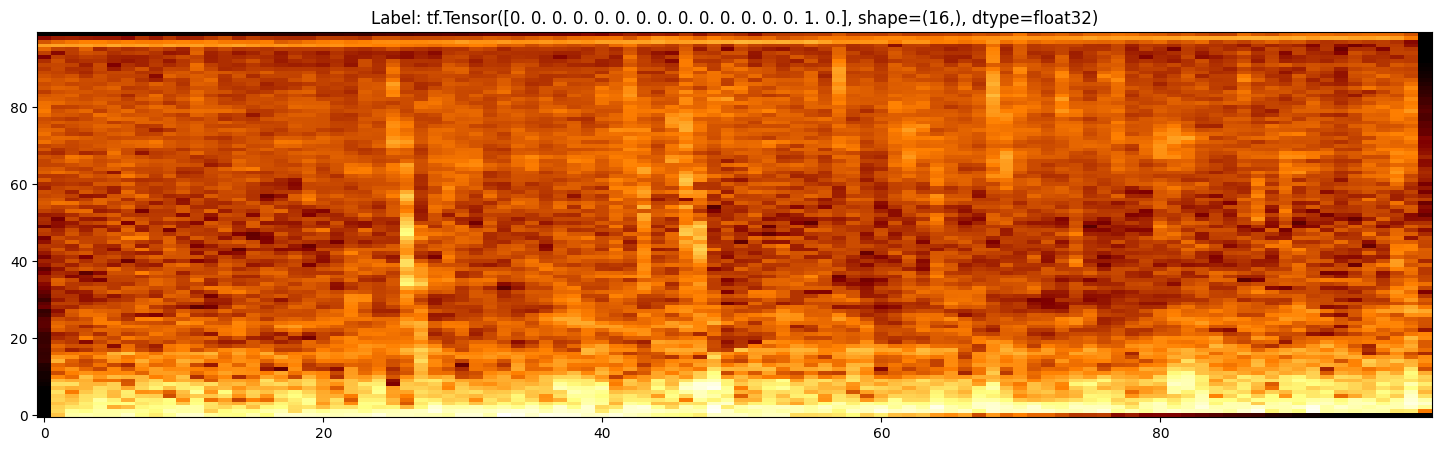

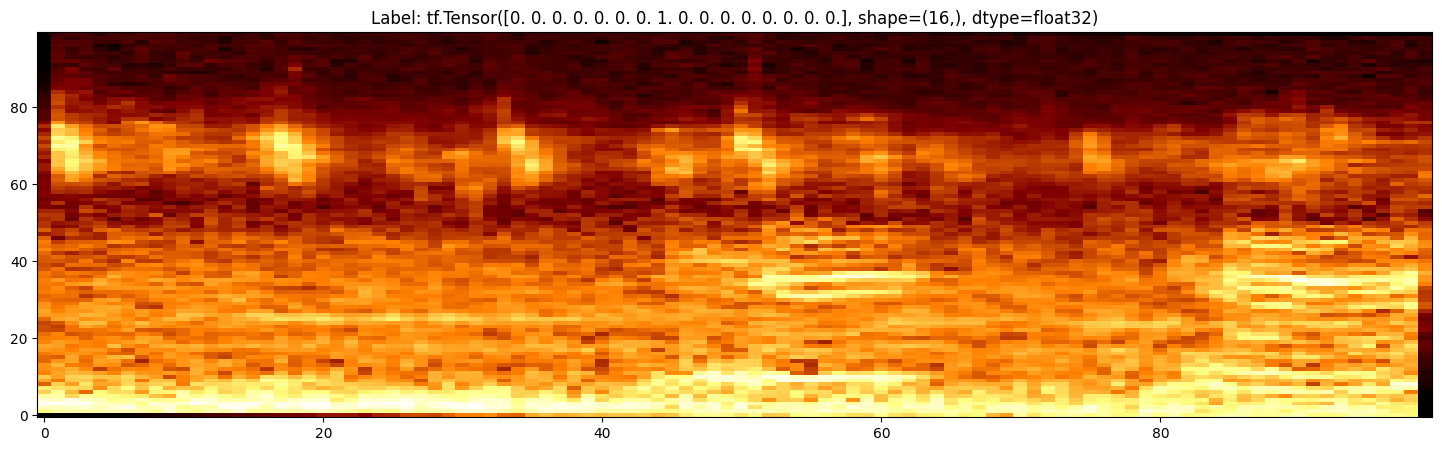

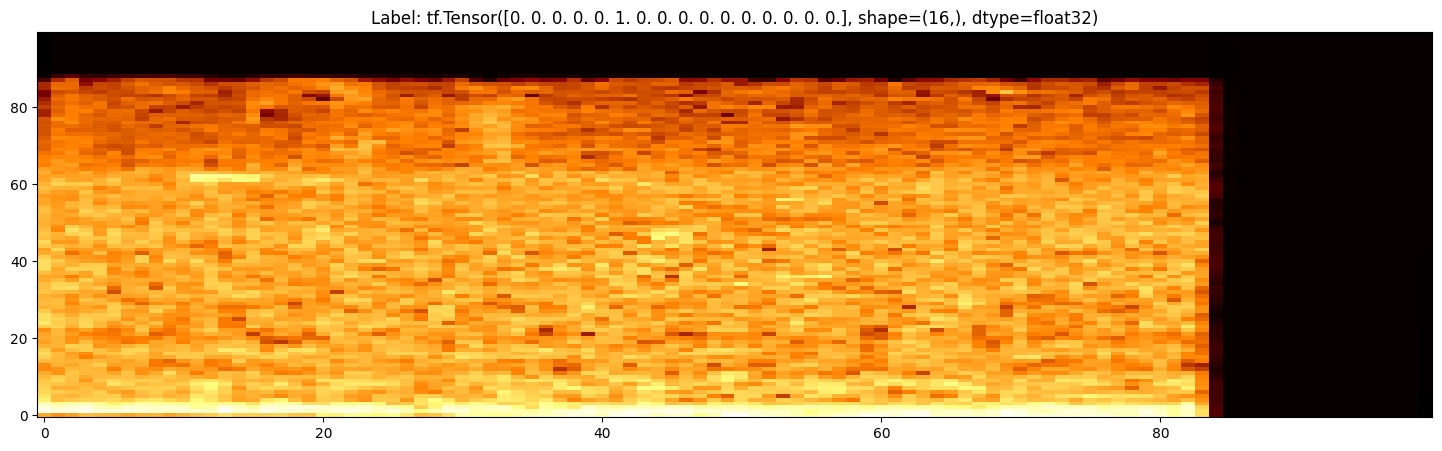

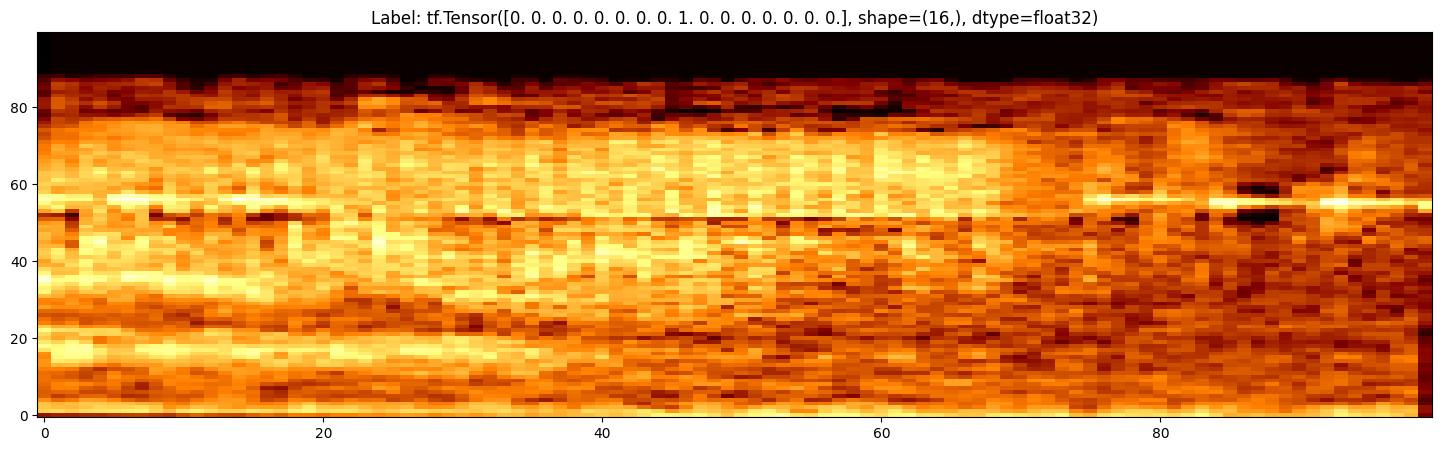

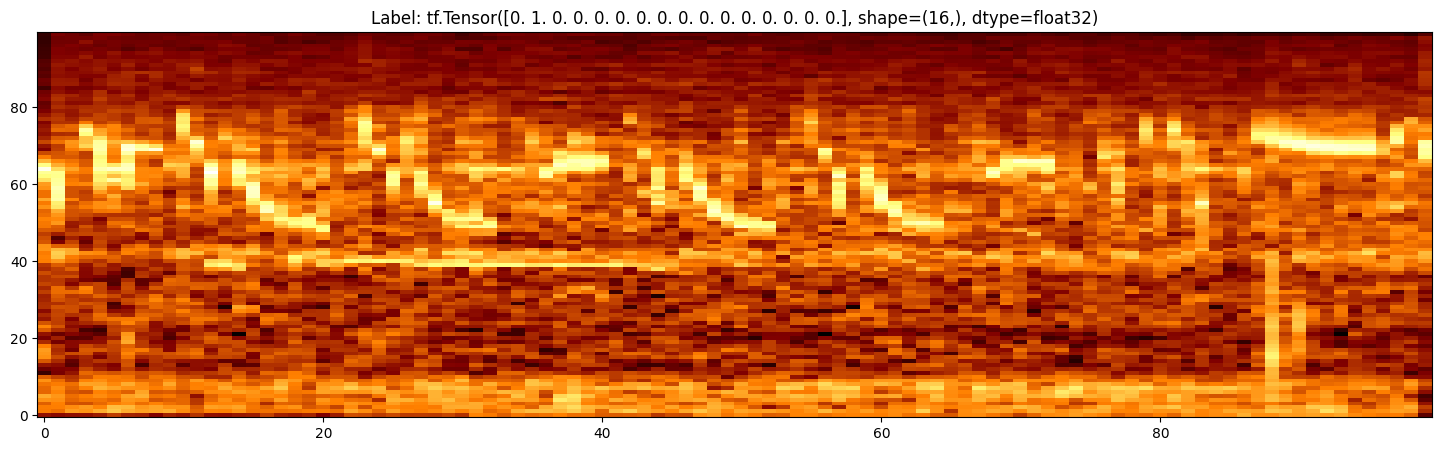

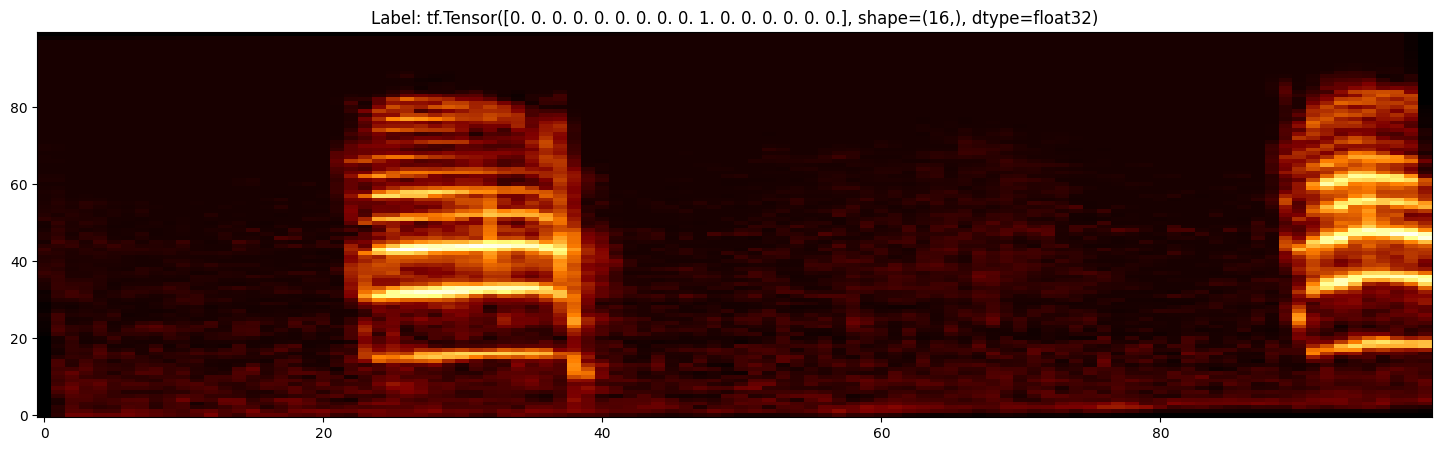

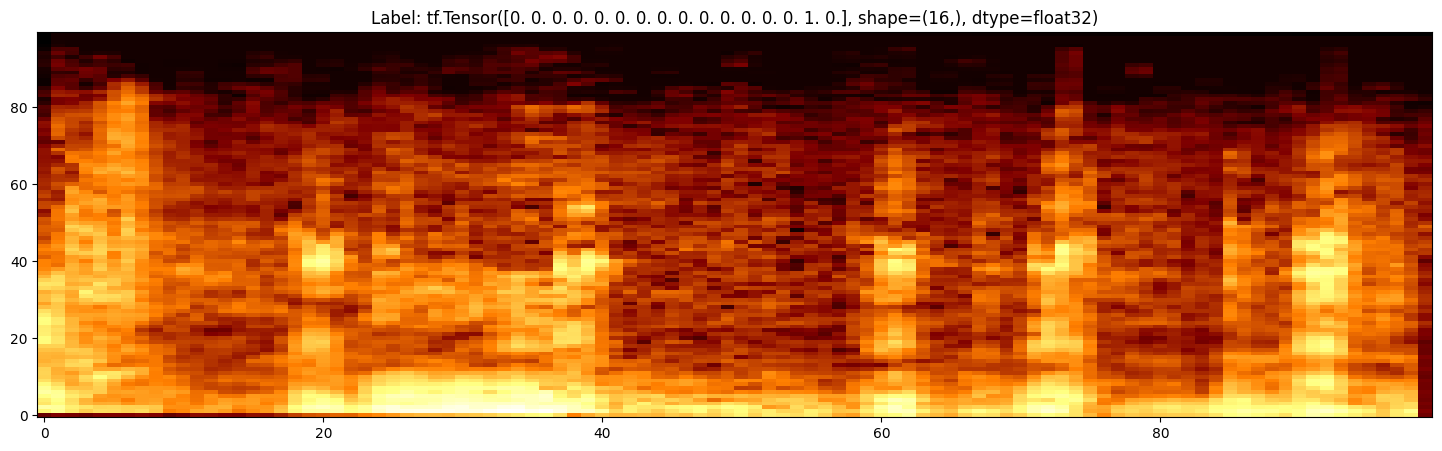

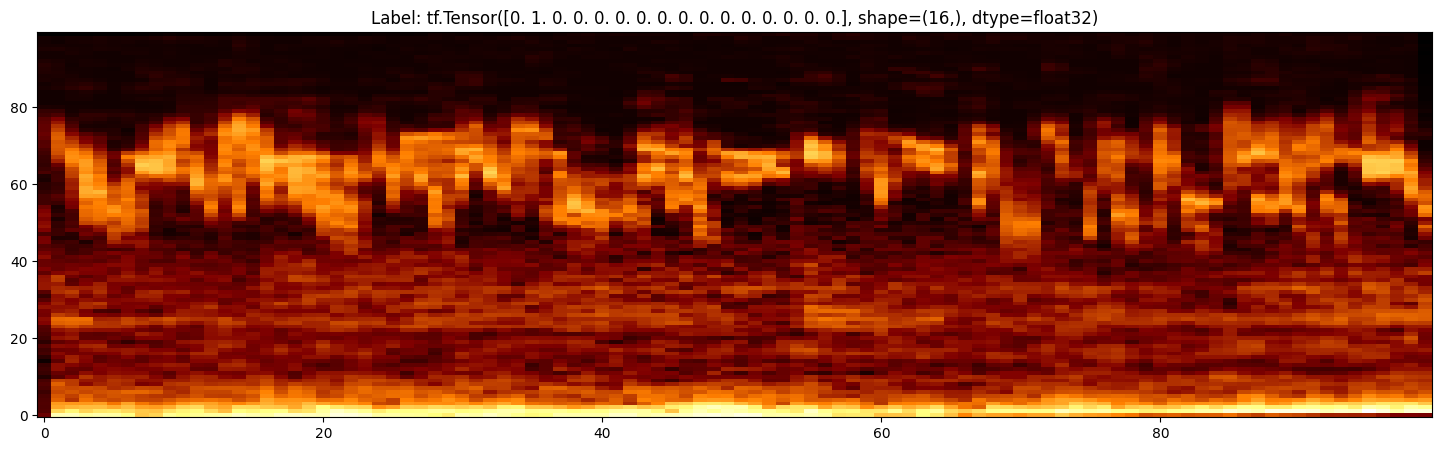

In [19]:
# Show what the pipeline looks like at this stage
# Take 1 from the training dataset
# Shows the melspectrogram shape and label info
# sample info shows batch (16), mel spec dimensions (260,260) and image (3)
# label info shows batch (16) and one-hot encoded labels (15) and array below
# Images printed to show that it works. Note the images are on a lean and there is part missing. This is deliberate and helps the model.
for melspectrogram,label in train_dataset.take(1):
    print(f' sample info: {melspectrogram.shape}, \n label info: {label.shape} \n {label}')
    for example in range(melspectrogram.shape[0]):
        plt.figure(figsize=(18,5))
        plt.imshow(melspectrogram[example,:,:,0].numpy().T, cmap='afmhot', origin='lower', aspect='auto')
        plt.title('Label: ' + str(label[example,:]))
        plt.show()

# Classification Model

Now that the images are produced, it moves into an image classification model.

In order to test whether the pipeline is working a CNN based image classification model is constructed below.  This model leverages pre-trained model weights for the EfficientNetV2 feature model which generates a vector representation of 1000 floats for each input image.  Note that on first run this model tensorflow hub library will check if model weights are available, and if not, will automatically download them to your computer.  This may take a few minutes the first time this is run.

The output from the EfficientNetV2 model is then fed into 2 fully connected layers to perform the classification function.

In [20]:
# The below function takes an input, which the the image dimensions below
# Runs through the EfficientNetV2 model
# Output is a vector (think about is as an image to vector conversion)
# Finally it maps it to the classes
# Output is a probability distribution over the classes

# def build_model(trainable):
#     # Build a classification model using a pre-trained EfficientNetV2
#     model = tf.keras.Sequential(
#         [
#             # Input layer with specified image dimensions
#              #'MODEL_INPUT_IMAGE_WIDTH': 260,
#              #'MODEL_INPUT_IMAGE_HEIGHT': 260,
#              #'MODEL_INPUT_IMAGE_CHANNELS': 3,
#             tf.keras.layers.InputLayer(input_shape=(SC['MODEL_INPUT_IMAGE_HEIGHT'], 
#                                                     SC['MODEL_INPUT_IMAGE_WIDTH'], 
#                                                     SC['MODEL_INPUT_IMAGE_CHANNELS'])),

#             # Use the EfficientNetV2 model as a feature generator (needs 260x260x3 images)
#             hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/classification/2", trainable),

#             # Add the classification layers
#             tf.keras.layers.Flatten(),
#             tf.keras.layers.BatchNormalization(),

#             # Fully connected layer with multiple of the number of classes
#             tf.keras.layers.Dense(len(class_names) * 8,
#                                   activation="relu"),
#             tf.keras.layers.BatchNormalization(),

#             # Another fully connected layer with multiple of the number of classes
#             tf.keras.layers.Dense(len(class_names) * 4,
#                                   activation="relu"),
#             tf.keras.layers.BatchNormalization(),

#             # Add dropout to reduce overfitting
#             tf.keras.layers.Dropout(0.50),

#             # Output layer with one node per class, without activation
#             tf.keras.layers.Dense(len(class_names), activation=None),
#         ]
#     )
#     # Set the input shape for the model
#     model.build([None, 
#                  SC['MODEL_INPUT_IMAGE_HEIGHT'],
#                  SC['MODEL_INPUT_IMAGE_WIDTH'], 
#                  SC['MODEL_INPUT_IMAGE_CHANNELS']])

#     # Display the model summary
#     model.summary()

#     return model



# def build_model(trainable=True):
#     input_shape = (SC['MODEL_INPUT_IMAGE_HEIGHT'], 
#                    SC['MODEL_INPUT_IMAGE_WIDTH'], 
#                    SC['MODEL_INPUT_IMAGE_CHANNELS'])
    
#     model = tf.keras.Sequential([
#         # 1. Input layer
#         tf.keras.layers.InputLayer(input_shape=input_shape),
        
#         # 2. Convolutional layers for feature extraction
#         tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
#         tf.keras.layers.MaxPooling2D((2, 2)),
#         tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
#         tf.keras.layers.MaxPooling2D((2, 2)),
#         tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
#         tf.keras.layers.MaxPooling2D((2, 2)),
        
#         # 3. Flatten the output
#         tf.keras.layers.Flatten(),
        
        
#         # 4. A smaller dense layer before VGGish
#         tf.keras.layers.Dense(3*6000, activation='relu'),
#         tf.keras.layers.Reshape((-1,)),
        
#         # 5. Use VGGish model for embeddings
#         hub.KerasLayer("https://tfhub.dev/google/vggish/1", trainable=trainable),
        
#         # 6. Additional layers for classification
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dense(len(class_names) * 8, activation="relu"),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dense(len(class_names) * 4, activation="relu"),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(0.50),
#         tf.keras.layers.Dense(len(class_names), activation=None),
#     ])
    
#     model.summary()
#     return model

# vggish_model = hub.load('https://tfhub.dev/google/vggish/1')
# def build_model(trainable=True):
#     input_shape = (SC['MODEL_INPUT_IMAGE_HEIGHT'], 
#                    SC['MODEL_INPUT_IMAGE_WIDTH'], 
#                    SC['MODEL_INPUT_IMAGE_CHANNELS'])
    
#     model = tf.keras.Sequential([
#         # 1. Input layer
#         tf.keras.layers.InputLayer(input_shape=input_shape),
        
#         # 2. Convolutional layers for feature extraction
#         tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
#         tf.keras.layers.MaxPooling2D((2, 2)),
#         tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
#         tf.keras.layers.MaxPooling2D((2, 2)),
#         tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
#         tf.keras.layers.MaxPooling2D((2, 2)),
        
#         # 3. Flatten the output
#         tf.keras.layers.Flatten(),
        
#         # 4. A smaller dense layer before VGGish
#         tf.keras.layers.Dense(3*6000, activation='relu'),
        
#         # 5. Use VGGish model for embeddings
#         tf.keras.layers.Lambda(lambda x: vggish_model(tf.reshape(x, [-1])), trainable=trainable),
        
#         # 6. Additional layers for classification
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dense(len(class_names) * 8, activation="relu"),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dense(len(class_names) * 4, activation="relu"),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(0.50),
#         tf.keras.layers.Dense(len(class_names), activation=None),
#     ])
    
#     model.summary()
#     return model

# # model = build_model(True)

In [21]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

# Load the VGGish model.
vggish_model = hub.load('https://tfhub.dev/google/vggish/1')

# Define a custom model.
def build_model(trainable=True):
    inputs = tf.keras.layers.Input(shape=(100, 100, 3))

    # Feature extraction.
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    # Flatten the tensor.
    x = tf.keras.layers.Flatten()(x)
    
    # Placeholder dense layer and reshape to align with VGGish's expected input.
    x = tf.keras.layers.Dense(3*6000, activation='relu')(x)
    x = tf.keras.layers.Reshape((3*6000,))(x)
    
#     # Embedding using VGGish model.
    x = tf.keras.layers.Lambda(lambda y: vggish_model(tf.reshape(y, [-1])))(x)
    
    
    # Postprocessing: Get the output to shape 16.
    x = tf.keras.layers.Dense(16, activation='softmax')(x)
    x = tf.keras.layers.Lambda(lambda y: y[:8])(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    
    return model

# # Compile and check the model summary.
# model = build_model(trainable=True)
# model.summary()


# Model Training

The following sets up callbacks to track model training and performs the model fit to train the model.

The callbacks will ensure the best model weights (as defined by lowest validation loss) will be written to disk during training.  This is important as the model training could take several hours (12+ hours) to complete and any errors may cause the training loop to exit - so having the checkpoints acts as a backup.  The model will stop training when it sees no further improvement to the validation loss, after which it will restore the best weights found.  This allows the training to discover when it is overfit and stop further training.  This is why the number of epics is 10000.  It is expected the model training will end significantly earlier than this.

In [22]:
if not os.path.exists('models/'):
    os.mkdir('models/')
if not os.path.exists('models/1'):
    os.mkdir('models/1')    
    
# allow all the weights to be trained
model = build_model(True)
model.summary()
# the form_logits means the loss function has the 'softmax' buillt in.  This approach is numerically more stable
# than including the softmax activation on the last layer of the classifier
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              metrics=["accuracy"],
              )

# tensorboard for visualisation of results
log_dir = "tensorboard_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1)

# reduce learning rate to avoid overshooting local minima
lr_reduce_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                      factor=0.75,
                                                      patience=8, 
                                                      verbose=1,
                                                      mode='min',
                                                      cooldown=0, 
                                                      min_lr=1e-7)

# end the training if no improvement for 16 epochs in a row, then restore best model weights
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=16,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

# save the best model as it trains..
mcp_save = tf.keras.callbacks.ModelCheckpoint('models/checkpoint_generic_model.hdf5', 
                                           save_best_only=True, 
                                           monitor='val_loss', 
                                           mode='min')

# any changes to the source code will generally require the disk cache to be cleared.
# So to be safe, the cache is cleared before training the model.  If you are sure
# the cache is still valid then comment out this code
# the first few epochs of the model training will be slow as the cache is populated with pipeline samples
# and will depend on the dataset size and the number of variants included
cache.clear()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        18496 

7581

In [23]:
model.fit(train_dataset, 
          validation_data=validation_dataset,
          callbacks=[lr_reduce_plateau, early_stopping, tensorboard_callback, mcp_save],
          epochs=SC['MAX_EPOCHS'])  

Epoch 1/5000
96/96 [==============================] - 284s 3s/step - loss: 2.7261 - accuracy: 0.1647 - val_loss: 2.6657 - val_accuracy: 0.2320 - lr: 1.0000e-04
Epoch 2/5000
96/96 [==============================] - 232s 2s/step - loss: 2.6794 - accuracy: 0.2039 - val_loss: 2.6446 - val_accuracy: 0.2320 - lr: 1.0000e-04
Epoch 3/5000
96/96 [==============================] - 250s 3s/step - loss: 2.6665 - accuracy: 0.2039 - val_loss: 2.6597 - val_accuracy: 0.2320 - lr: 1.0000e-04
Epoch 4/5000
96/96 [==============================] - 251s 3s/step - loss: 2.6710 - accuracy: 0.2026 - val_loss: 2.6327 - val_accuracy: 0.2320 - lr: 1.0000e-04
Epoch 5/5000
96/96 [==============================] - 220s 2s/step - loss: 2.6574 - accuracy: 0.2105 - val_loss: 2.6162 - val_accuracy: 0.2320 - lr: 1.0000e-04
Epoch 6/5000
96/96 [==============================] - 231s 2s/step - loss: 2.6462 - accuracy: 0.2261 - val_loss: 2.6206 - val_accuracy: 0.2652 - lr: 1.0000e-04
Epoch 7/5000
96/96 [====================

Epoch 51/5000
96/96 [==============================] - 191s 2s/step - loss: 2.5744 - accuracy: 0.2993 - val_loss: 2.5309 - val_accuracy: 0.3425 - lr: 7.5000e-05
Epoch 52/5000
96/96 [==============================] - 199s 2s/step - loss: 2.5680 - accuracy: 0.3085 - val_loss: 2.5308 - val_accuracy: 0.3591 - lr: 7.5000e-05
Epoch 53/5000
96/96 [==============================] - 188s 2s/step - loss: 2.5742 - accuracy: 0.3033 - val_loss: 2.5350 - val_accuracy: 0.3646 - lr: 7.5000e-05
Epoch 54/5000
96/96 [==============================] - 197s 2s/step - loss: 2.5807 - accuracy: 0.2810 - val_loss: 2.5278 - val_accuracy: 0.3536 - lr: 7.5000e-05
Epoch 55/5000
96/96 [==============================] - 197s 2s/step - loss: 2.5744 - accuracy: 0.2967 - val_loss: 2.5556 - val_accuracy: 0.3260 - lr: 7.5000e-05
Epoch 56/5000
96/96 [==============================] - 196s 2s/step - loss: 2.5552 - accuracy: 0.3268 - val_loss: 2.5372 - val_accuracy: 0.3315 - lr: 7.5000e-05
Epoch 57/5000
96/96 [=============

Epoch 99/5000
96/96 [==============================] - 188s 2s/step - loss: 2.5433 - accuracy: 0.3346 - val_loss: 2.5080 - val_accuracy: 0.3702 - lr: 3.1641e-05
Epoch 100/5000
96/96 [==============================] - 197s 2s/step - loss: 2.5369 - accuracy: 0.3412 - val_loss: 2.5131 - val_accuracy: 0.3702 - lr: 3.1641e-05
Epoch 101/5000
96/96 [==============================] - 198s 2s/step - loss: 2.5535 - accuracy: 0.3268 - val_loss: 2.5029 - val_accuracy: 0.3757 - lr: 3.1641e-05
Epoch 102/5000
96/96 [==============================] - 192s 2s/step - loss: 2.5447 - accuracy: 0.3373 - val_loss: 2.5065 - val_accuracy: 0.3702 - lr: 3.1641e-05
Epoch 103/5000
96/96 [==============================] - 202s 2s/step - loss: 2.5570 - accuracy: 0.3176 - val_loss: 2.5279 - val_accuracy: 0.3481 - lr: 3.1641e-05
Epoch 104/5000
96/96 [==============================] - 216s 2s/step - loss: 2.5403 - accuracy: 0.3386 - val_loss: 2.5071 - val_accuracy: 0.3646 - lr: 3.1641e-05
Epoch 105/5000
96/96 [=======

KeyboardInterrupt: 

# Model Predictions on test data

The following provides an example of how to use the trained model to perform inference (predictions).  It calculates the best class and the probability for that class.

In [24]:
# Function to predict class and probability given a prediction
def predict_class(predictions):
    # Get the index of the class with the highest predicted probability
    predicted_index = int(tf.argmax(tf.squeeze(predictions)).numpy())
    # Get the class name using the predicted index
    predicted_class = class_names[predicted_index]
    # Calculate the predicted probability for the selected class
    predicted_probability = 100.0 * tf.nn.softmax(predictions)[predicted_index].numpy()
    # Round the probability to 2 decimal places
    predicted_probability = str(round(predicted_probability, 2))
    return predicted_class, predicted_probability

# Display class names and run prediction on test entries
print(f'Class names: {class_names}')
for features, labels in test_dataset:
    # Generate predictions for the given features
    predictions = model.predict(features, verbose=0)

    # Iterate over each item in the batch
    for batch_idx in range(predictions.shape[0]):
        # Get the index of the true class
        true_index = int(tf.argmax(tf.squeeze(labels[batch_idx])).numpy())
        # Get the true class name using the true index
        true_class = class_names[true_index]

        # Predict class and probability using the prediction function
        predicted_class, predicted_probability = predict_class(predictions[batch_idx])

        print(f'True class      : {true_class}')
        print(f'Predicted class : {predicted_class}')
        print(f'Predicted probability : {predicted_probability}')

Class names: ['Aegotheles cristatus Australian owlet-nightjar', 'Alauda arvensis European Skylark', 'Caligavis chrysops Yellow-faced honeyeater', 'Capra hircus Feral goat', 'Cervus unicolour Sambar deer', 'Colluricincla harmonica Grey shrikethrush', 'Corvus coronoides Australian raven', 'Dama dama Fallow Deer', 'Eopsaltria australis Eastern yellow robin', 'Felis Catus Cat', 'Pachycephala rufiventris Rufous whistler', 'Ptilotula penicillata White-plumed honeyeater', 'Rattus norvegicus Brown rat', 'Strepera graculina Pied currawong', 'sus scrofa Wild pig', 'vulpes vulpes red fox']
True class      : Felis Catus Cat
Predicted class : Colluricincla harmonica Grey shrikethrush
Predicted probability : 12.98
True class      : Caligavis chrysops Yellow-faced honeyeater
Predicted class : Eopsaltria australis Eastern yellow robin
Predicted probability : 9.15
True class      : Felis Catus Cat
Predicted class : Felis Catus Cat
Predicted probability : 15.34
True class      : Aegotheles cristatus Aus

In [25]:
# Save the full model for use with tensorflow serving
model.save('models/echo_model/1/', overwrite=True)

AssertionError: Tried to export a function which references an 'untracked' resource. TensorFlow objects (e.g. tf.Variable) captured by functions must be 'tracked' by assigning them to an attribute of a tracked object or assigned to an attribute of the main object directly. See the information below:
	Function name = b'__inference_signature_wrapper_202806'
	Captured Tensor = <ResourceHandle(name="Resource-19-at-0x204bb96a0c0", device="/job:localhost/replica:0/task:0/device:CPU:0", container="Anonymous", type="class tensorflow::Var", dtype and shapes : "[ DType enum: 1, Shape: [3,3,1,64] ]")>
	Trackable referencing this tensor = <tf.Variable 'vggish/conv1/weights:0' shape=(3, 3, 1, 64) dtype=float32>
	Internal Tensor = Tensor("202764:0", shape=(), dtype=resource)

Students Note:
This is step 1 of engine complete - how to create and save a model. Now you need to head over to echo_engine.py